<a href="https://colab.research.google.com/github/javeenkumar/Sign_language_model/blob/main/Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install kaggle --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [2]:
!pip uninstall -y kagglehub kagglesdk

Found existing installation: kagglehub 0.3.13
Uninstalling kagglehub-0.3.13:
  Successfully uninstalled kagglehub-0.3.13
Found existing installation: kagglesdk 0.1.15
Uninstalling kagglesdk-0.1.15:
  Successfully uninstalled kagglesdk-0.1.15


In [3]:
# !pip install kaggle --upgrade
!pip uninstall -y kaggle
!pip install kaggle==1.6.14

Found existing installation: kaggle 2.0.0
Uninstalling kaggle-2.0.0:
  Successfully uninstalled kaggle-2.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105121 sha256=006e35041313882d140eefe6073e85b3f9143eba428c2cc69e73798a4e27004c
  Stored in directory: /root/.cache/pip/wheels/89/bc/52/0d140fc172783e1e72e3af4dfc13015dc154527fafb95e65cd
Successfully built kaggle


In [5]:
from google.colab import files
files.upload()

In [6]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip -d asl-alphabet

!kaggle datasets download -d ayuraj/asl-dataset
!unzip -q asl-dataset.zip -d asl-dataset

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 99% 1.02G/1.03G [00:12<00:00, 116MB/s]
100% 1.03G/1.03G [00:12<00:00, 90.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset
License(s): CC0-1.0
 62% 35.0M/56.9M [00:00<00:00, 174MB/s] 
100% 56.9M/56.9M [00:00<00:00, 184MB/s]


In [7]:
# ============================================================
# INSTALL REQUIRED PACKAGES
# ============================================================
!pip install --quiet mediapipe tensorflow opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-hub 0.21.1 requires kagglehub, which is not installed.


In [8]:
!pip install kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
  Using cached kagglesdk-0.1.15-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.2 MB/s eta 0:00:00
Using cached kagglesdk-0.1.15-py3-none-any.whl (160 kB)


In [ ]:
# ============================================================================
# REAL-TIME ASL MODEL TRAINING (IMAGE + MEDIAPIPE LANDMARKS)||MODEL 1||
# ============================================================================

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import random
import json
import gc
from datetime import datetime
import cv2
import mediapipe as mp

# ============================================================================
# GPU SETUP + INFO
# ============================================================================
tf.keras.backend.clear_session()
gc.collect()

print("=" * 70)
print("🎯 REAL-TIME ASL MODEL TRAINING WITH HAND LANDMARKS")
print("=" * 70)
print(f"✅ GPU: {tf.config.list_physical_devices('GPU')}")
print(f"✅ TensorFlow: {tf.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================
TRAIN_PATH = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10
CHECKPOINT_DIR = "/content/checkpoints"
MAX_IMAGES_PER_CLASS = 800

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"\n⚙️ Config: {IMG_SIZE}×{IMG_SIZE} | Batch: {BATCH_SIZE}")

# ============================================================================
# MEDIAPIPE HAND LANDMARKER (NEW TASKS API)
# ============================================================================
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

TASK_PATH = "/content/hand_landmarker.task"
if not os.path.exists(TASK_PATH):
    !wget -q https://storage.googleapis.com/mediapipe-assets/hand_landmarker.task -O {TASK_PATH}

base_options = python.BaseOptions(model_asset_path=TASK_PATH)
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
hand_landmarker = vision.HandLandmarker.create_from_options(options)

def extract_landmarks(img_rgb):
    """Extract normalized (x,y) coordinates for 21 landmarks."""
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    result = hand_landmarker.detect(mp_image)
    if result.hand_landmarks:
        lms = np.array([[lm.x, lm.y] for lm in result.hand_landmarks[0]]).flatten()
    else:
        lms = np.zeros(42, dtype=np.float32)
    return lms

# ============================================================================
# DATA PIPELINE
# ============================================================================
print("\n📦 Loading dataset...")

def _extract_landmarks_tf(path):
    """Safe inside tf.py_function — uses .numpy().decode('utf-8')."""
    path_str = path.numpy().decode("utf-8")
    img = cv2.imread(path_str)
    if img is None:
        return np.zeros(42, dtype=np.float32)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return extract_landmarks(img_rgb).astype(np.float32)

def create_dataset(directory, subset, batch_size, max_per_class):
    all_files = []
    class_names = sorted([d for d in os.listdir(directory)
                          if os.path.isdir(os.path.join(directory, d))])
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        files = glob.glob(os.path.join(class_dir, "*.jpg"))[:max_per_class]
        all_files.extend([(f, class_idx) for f in files])

    random.seed(42)
    random.shuffle(all_files)
    split_idx = int(0.8 * len(all_files))
    files = all_files[:split_idx] if subset == "training" else all_files[split_idx:]

    paths = [f[0] for f in files]
    labels = [f[1] for f in files]

    def load_preprocess(path, label):
        # Read + preprocess image
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.cast(img, tf.float32) / 255.0

        # Extract MediaPipe landmarks (executed eagerly)
        lms = tf.py_function(func=_extract_landmarks_tf, inp=[path], Tout=tf.float32)
        lms.set_shape([42])

        if subset == "training":
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)

        return (img, lms), label

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if subset == "training":
        ds = ds.shuffle(2000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds, class_names, len(files)

train_ds, class_names, train_count = create_dataset(TRAIN_PATH, "training", BATCH_SIZE, MAX_IMAGES_PER_CLASS)
val_ds, _, val_count = create_dataset(TRAIN_PATH, "validation", BATCH_SIZE, MAX_IMAGES_PER_CLASS)
NUM_CLASSES = len(class_names)
print(f"✅ Training: {train_count} | Validation: {val_count} | Classes: {NUM_CLASSES}")

# ============================================================================
# BUILD HYBRID MODEL (IMAGE + LANDMARKS)
# ============================================================================
print("\n🧠 Building hybrid model (Image + Landmarks)...")

# Image branch
img_input = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
    alpha=0.35
)
base_model.trainable = False
x = base_model(img_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)

# Landmark branch
lm_input = keras.Input(shape=(42,), name="landmark_input")
y = layers.Dense(64, activation="relu")(lm_input)
y = layers.Dense(32, activation="relu")(y)

# Merge branches
combined = layers.concatenate([x, y])
combined = layers.Dense(64, activation="relu")(combined)
combined = layers.Dropout(0.3)(combined)
output = layers.Dense(NUM_CLASSES, activation="softmax")(combined)

model = keras.Model(inputs=[img_input, lm_input], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
print(model.summary())

# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\n🚀 Training hybrid model...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1)

# ============================================================================
# FINE-TUNE TOP LAYERS
# ============================================================================
print("\n🔥 Fine-tuning MobileNet top layers...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE2)

# ============================================================================
# EXPORT
# ============================================================================
print("\n📱 Saving model + labels...")
model.save("/content/Model_landmarks.keras")
with open("/content/class_names.txt", "w") as f:
    f.write("\n".join(class_names))
print("✅ Model + class names saved successfully.")

In [20]:
# ============================================================================
# REAL-TIME ASL MODEL TRAINING (IMAGE + MEDIAPIPE LANDMARKS) ||MODEL 2||
# ============================================================================

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import random
import json
import gc
from datetime import datetime
import cv2
import mediapipe as mp

# ============================================================================
# GPU SETUP + INFO
# ============================================================================
tf.keras.backend.clear_session()
gc.collect()

print("=" * 70)
print("🎯 REAL-TIME ASL MODEL TRAINING WITH HAND LANDMARKS")
print("=" * 70)
print(f"✅ GPU: {tf.config.list_physical_devices('GPU')}")
print(f"✅ TensorFlow: {tf.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================
# Try multiple possible paths
POSSIBLE_PATHS = [
    "/content/asl-dataset/asl_dataset",
    "/content/asl_dataset",
]

TRAIN_PATH = None
for path in POSSIBLE_PATHS:
    if os.path.exists(path):
        TRAIN_PATH = path
        print(f"✅ Found dataset at: {path}")
        break

if TRAIN_PATH is None:
    # List what's available
    print("❌ Available paths in /content:")
    for item in os.listdir("/content"):
        print(f"   - {item}")
    raise ValueError("Dataset not found! Please check the path.")

IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10
CHECKPOINT_DIR = "/content/checkpoints"
MAX_IMAGES_PER_CLASS = 800

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"\n⚙️ Config: {IMG_SIZE}×{IMG_SIZE} | Batch: {BATCH_SIZE}")

# ============================================================================
# MEDIAPIPE HAND LANDMARKER (NEW TASKS API)
# ============================================================================
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

TASK_PATH = "/content/hand_landmarker.task"
if not os.path.exists(TASK_PATH):
    import urllib.request
    print("⬇️ Downloading hand landmarker model...")
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/mediapipe-assets/hand_landmarker.task",
        TASK_PATH
    )
    print("✅ Downloaded!")

base_options = python.BaseOptions(model_asset_path=TASK_PATH)
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
hand_landmarker = vision.HandLandmarker.create_from_options(options)

def extract_landmarks(img_rgb):
    """Extract normalized (x,y) coordinates for 21 landmarks."""
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
    result = hand_landmarker.detect(mp_image)
    if result.hand_landmarks:
        lms = np.array([[lm.x, lm.y] for lm in result.hand_landmarks[0]]).flatten()
    else:
        lms = np.zeros(42, dtype=np.float32)
    return lms

# ============================================================================
# DATA PIPELINE
# ============================================================================
print("\n📦 Loading dataset...")

def _extract_landmarks_tf(path):
    """Safe inside tf.py_function — uses .numpy().decode('utf-8')."""
    path_str = path.numpy().decode("utf-8")
    img = cv2.imread(path_str)
    if img is None:
        return np.zeros(42, dtype=np.float32)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return extract_landmarks(img_rgb).astype(np.float32)

def create_dataset(directory, subset, batch_size, max_per_class):
    all_files = []

    # Debug: Show directory structure
    print(f"🔍 Scanning: {directory}")
    if os.path.exists(directory):
        items = os.listdir(directory)
        print(f"   Found {len(items)} items: {items[:5]}...")  # Show first 5

    class_names = sorted([d for d in os.listdir(directory)
                          if os.path.isdir(os.path.join(directory, d))])

    print(f"   Classes found: {class_names}")

    # Support multiple image extensions
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        files = []
        for ext in extensions:
            files.extend(glob.glob(os.path.join(class_dir, ext)))
        files = files[:max_per_class]
        all_files.extend([(f, class_idx) for f in files])

        if class_idx < 3:  # Debug first 3 classes
            print(f"   Class '{class_name}': {len(files)} images")

    if len(all_files) == 0:
        raise ValueError(f"No images found in {directory}. Check if images are in subdirectories.")

    random.seed(42)
    random.shuffle(all_files)
    split_idx = int(0.8 * len(all_files))
    files = all_files[:split_idx] if subset == "training" else all_files[split_idx:]

    print(f"   Total {subset}: {len(files)} images")

    # Convert to numpy arrays with proper dtypes
    paths = np.array([f[0] for f in files], dtype=str)
    labels = np.array([f[1] for f in files], dtype=np.int32)

    def load_preprocess(path, label):
        # Read + preprocess image
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.cast(img, tf.float32) / 255.0

        # Extract MediaPipe landmarks
        lms = tf.py_function(func=_extract_landmarks_tf, inp=[path], Tout=tf.float32)
        lms.set_shape([42])

        if subset == "training":
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)

        return (img, lms), label

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if subset == "training":
        ds = ds.shuffle(2000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds, class_names, len(files)

train_ds, class_names, train_count = create_dataset(TRAIN_PATH, "training", BATCH_SIZE, MAX_IMAGES_PER_CLASS)
val_ds, _, val_count = create_dataset(TRAIN_PATH, "validation", BATCH_SIZE, MAX_IMAGES_PER_CLASS)
NUM_CLASSES = len(class_names)
print(f"\n✅ Training: {train_count} | Validation: {val_count} | Classes: {NUM_CLASSES}")

# ============================================================================
# BUILD HYBRID MODEL (IMAGE + LANDMARKS)
# ============================================================================
print("\n🧠 Building hybrid model (Image + Landmarks)...")

# Image branch
img_input = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
    alpha=0.35
)
base_model.trainable = False
x = base_model(img_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)

# Landmark branch
lm_input = keras.Input(shape=(42,), name="landmark_input")
y = layers.Dense(64, activation="relu")(lm_input)
y = layers.Dense(32, activation="relu")(y)

# Merge branches
combined = layers.concatenate([x, y])
combined = layers.Dense(64, activation="relu")(combined)
combined = layers.Dropout(0.3)(combined)
output = layers.Dense(NUM_CLASSES, activation="softmax")(combined)

model = keras.Model(inputs=[img_input, lm_input], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
print(model.summary())

# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\n🚀 Training hybrid model...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1)

# ============================================================================
# FINE-TUNE TOP LAYERS
# ============================================================================
print("\n🔥 Fine-tuning MobileNet top layers...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE2)

# ============================================================================
# EXPORT
# ============================================================================
print("\n📱 Saving model + labels...")
model.save("/content/asl_realtime_landmarks.keras")
with open("/content/class_names.txt", "w") as f:
    f.write("\n".join(class_names))
print("✅ Model + class names saved successfully.")

🎯 REAL-TIME ASL MODEL TRAINING WITH HAND LANDMARKS
✅ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ TensorFlow: 2.19.0
✅ Found dataset at: /content/asl-dataset/asl_dataset

⚙️ Config: 96×96 | Batch: 32
⬇️ Downloading hand landmarker model...
✅ Downloaded!

📦 Loading dataset...
🔍 Scanning: /content/asl-dataset/asl_dataset
   Found 26 items: ['k', 's', 'y', 'h', 'l']...
   Classes found: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
   Class 'a': 70 images
   Class 'b': 70 images
   Class 'c': 70 images
   Total training: 1452 images
🔍 Scanning: /content/asl-dataset/asl_dataset
   Found 26 items: ['k', 's', 'y', 'h', 'l']...
   Classes found: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
   Class 'a': 70 images
   Class 'b': 70 images
   Class 'c': 70 images
   Total validation: 363 images

✅ T

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_0.35_96 │ (None, 3, 3,      │    410,208 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ landmark_input      │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_0.35… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,752 │ landmark_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     81,984 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 26)        │      1,690 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 504,922 (1.93 MB)

 Trainable params: 94,714 (369.98 KB)

 Non-trainable params: 410,208 (1.56 MB)

None

🚀 Training hybrid model...
Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 803ms/step - accuracy: 0.1854 - loss: 2.8927 - val_accuracy: 0.7521 - val_loss: 1.2826
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 272ms/step - accuracy: 0.6332 - loss: 1.2002 - val_accuracy: 0.8567 - val_loss: 0.6206
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 274ms/step - accuracy: 0.8119 - loss: 0.6782 - val_accuracy: 0.9146 - val_loss: 0.4105
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 280ms/step - accuracy: 0.8695 - loss: 0.4492 - val_accuracy: 0.9366 - val_loss: 0.2977
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 280ms/step - accuracy: 0.9355 - loss: 0.3078 - val_accuracy: 0.9256 - val_loss: 0.2528
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 276ms/step - accuracy: 0.9376 - loss: 0.2423 - val_accuracy: 0.9421 - val_loss: 0.2359
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 275ms/step - accuracy: 0.9441 - loss: 0.1964 - val_accuracy: 0.9587 - val_loss: 0.1766
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 284ms/step - accurac

In [ ]:
# ========================================================================
# SAVE TRAINED HYBRID MODEL + MEDIAPIPE LANDMARK DATA
# ========================================================================

import json, os, cv2, glob, numpy as np
from tqdm import tqdm

# ----- 1️⃣ SAVE TRAINED HYBRID MODEL -----
MODEL_PATH = "/content/asl_realtime_landmarks.keras"
CLASS_PATH = "/content/class_names.txt"

model.save(MODEL_PATH)
with open(CLASS_PATH, "w") as f:
    f.write("\n".join(class_names))

print(f"✅ Hybrid model saved: {MODEL_PATH}")
print(f"✅ Class names saved: {CLASS_PATH}")

# ----- 2️⃣ SAVE MEDIAPIPE LANDMARK DATA -----
LANDMARKS_PATH = "/content/asl_landmarks.json"
print("\n🖐 Extracting and saving MediaPipe landmarks...")

all_landmarks = {}

for class_name in sorted(os.listdir(TRAIN_PATH)):
    class_dir = os.path.join(TRAIN_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue

    all_landmarks[class_name] = []
    print(f"📸 Processing class: {class_name}")

    # Limit to MAX_IMAGES_PER_CLASS to keep dataset balanced
    image_paths = glob.glob(os.path.join(class_dir, "*.jpg"))[:MAX_IMAGES_PER_CLASS]

    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lms = extract_landmarks(img_rgb).tolist()
        all_landmarks[class_name].append({"path": img_path, "landmarks": lms})

# Save to JSON
with open(LANDMARKS_PATH, "w") as f:
    json.dump(all_landmarks, f)

print(f"\n✅ All MediaPipe landmarks saved to: {LANDMARKS_PATH}")
print("🎯 Model + landmark data successfully saved!")

✅ Hybrid model saved: /content/asl_realtime_landmarks.keras
✅ Class names saved: /content/class_names.txt

🖐 Extracting and saving MediaPipe landmarks...
📸 Processing class: A


100%|██████████| 800/800 [00:39<00:00, 20.39it/s]


📸 Processing class: B


100%|██████████| 800/800 [00:35<00:00, 22.27it/s]


📸 Processing class: C


100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


📸 Processing class: D


100%|██████████| 800/800 [00:36<00:00, 22.21it/s]


📸 Processing class: E


100%|██████████| 800/800 [00:36<00:00, 22.02it/s]


📸 Processing class: F


100%|██████████| 800/800 [00:39<00:00, 20.42it/s]


📸 Processing class: G


100%|██████████| 800/800 [00:36<00:00, 21.73it/s]


📸 Processing class: H


100%|██████████| 800/800 [00:36<00:00, 21.87it/s]


📸 Processing class: I


100%|██████████| 800/800 [00:36<00:00, 21.74it/s]


📸 Processing class: J


100%|██████████| 800/800 [00:37<00:00, 21.29it/s]


📸 Processing class: K


100%|██████████| 800/800 [00:38<00:00, 20.93it/s]


📸 Processing class: L


100%|██████████| 800/800 [00:36<00:00, 21.91it/s]


📸 Processing class: M


100%|██████████| 800/800 [00:32<00:00, 24.31it/s]


📸 Processing class: N


100%|██████████| 800/800 [00:31<00:00, 25.34it/s]


📸 Processing class: O


100%|██████████| 800/800 [00:35<00:00, 22.79it/s]


📸 Processing class: P


100%|██████████| 800/800 [00:35<00:00, 22.70it/s]


📸 Processing class: Q


100%|██████████| 800/800 [00:35<00:00, 22.78it/s]


📸 Processing class: R


100%|██████████| 800/800 [00:37<00:00, 21.21it/s]


📸 Processing class: S


100%|██████████| 800/800 [00:37<00:00, 21.45it/s]


📸 Processing class: T


100%|██████████| 800/800 [00:35<00:00, 22.25it/s]


📸 Processing class: U


100%|██████████| 800/800 [00:37<00:00, 21.56it/s]


📸 Processing class: V


100%|██████████| 800/800 [00:37<00:00, 21.42it/s]


📸 Processing class: W


100%|██████████| 800/800 [00:36<00:00, 21.76it/s]


📸 Processing class: X


100%|██████████| 800/800 [00:36<00:00, 22.12it/s]


📸 Processing class: Y


100%|██████████| 800/800 [00:37<00:00, 21.36it/s]


📸 Processing class: Z


100%|██████████| 800/800 [00:36<00:00, 22.12it/s]


📸 Processing class: del


100%|██████████| 800/800 [00:33<00:00, 23.77it/s]


📸 Processing class: nothing


100%|██████████| 800/800 [00:24<00:00, 32.49it/s]


📸 Processing class: space


100%|██████████| 800/800 [00:34<00:00, 23.45it/s]



✅ All MediaPipe landmarks saved to: /content/asl_landmarks.json
🎯 Model + landmark data successfully saved!


In [ ]:
# # ============================================================================
# # REAL-TIME ASL PREDICTION (IMAGE + MEDIAPIPE LANDMARKS)
# # ============================================================================

# import os
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# import mediapipe as mp

# # ============================================================================
# # CONFIGURATION
# # ============================================================================
# MODEL_PATH = "/content/asl_realtime_landmarks.keras"  # or local path to your saved model
# LABELS_PATH = "/content/class_names.txt"
# TASK_PATH = "/content/hand_landmarker.task"
# IMG_SIZE = 96

# # ============================================================================
# # LOAD MODEL + CLASS NAMES
# # ============================================================================
# print("📦 Loading model and class names...")
# model = keras.models.load_model(MODEL_PATH)
# with open(LABELS_PATH, "r") as f:
#     class_names = [line.strip() for line in f.readlines()]
# print(f"✅ Loaded {len(class_names)} classes.")

# # ============================================================================
# # LOAD MEDIAPIPE HAND LANDMARKER
# # ============================================================================
# from mediapipe.tasks import python
# from mediapipe.tasks.python import vision

# if not os.path.exists(TASK_PATH):
#     !wget -q https://storage.googleapis.com/mediapipe-assets/hand_landmarker.task -O {TASK_PATH}

# base_options = python.BaseOptions(model_asset_path=TASK_PATH)
# options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
# hand_landmarker = vision.HandLandmarker.create_from_options(options)

# def extract_landmarks(img_rgb):
#     """Extract normalized (x, y) coordinates for 21 hand landmarks."""
#     mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
#     result = hand_landmarker.detect(mp_image)
#     if result.hand_landmarks:
#         lms = np.array([[lm.x, lm.y] for lm in result.hand_landmarks[0]]).flatten()
#     else:
#         lms = np.zeros(42, dtype=np.float32)
#     return lms

# # ============================================================================
# # PREDICTION FUNCTION
# # ============================================================================
# def predict_from_image(img_path):
#     """Predict the ASL class from an image path."""
#     if not os.path.exists(img_path):
#         print("❌ Image file not found:", img_path)
#         return

#     # Load image
#     img = cv2.imread(img_path)
#     if img is None:
#         print("❌ Failed to read image.")
#         return
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Extract landmarks
#     landmarks = extract_landmarks(img_rgb)

#     # Resize and normalize image
#     img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
#     img_resized = img_resized.astype(np.float32) / 255.0

#     # Expand dimensions for batch size
#     img_input = np.expand_dims(img_resized, axis=0)
#     lm_input = np.expand_dims(landmarks, axis=0)

#     # Predict
#     preds = model.predict({"image_input": img_input, "landmark_input": lm_input})
#     pred_idx = np.argmax(preds[0])
#     confidence = preds[0][pred_idx] * 100

#     print(f"🖼️ Prediction: {class_names[pred_idx]} ({confidence:.2f}%)")

# # ============================================================================
# # RUN PREDICTION (UPLOAD IMAGE FROM DESKTOP)
# # ============================================================================
# from google.colab import files

# uploaded = files.upload()  # Choose an image from desktop
# for filename in uploaded.keys():
#     predict_from_image(filename)

📦 Loading model and class names...
✅ Loaded 29 classes.


Saving letter-e-sign-language-581409.jpg to letter-e-sign-language-581409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🖼️ Prediction: X (39.19%)


In [35]:
# # ============================================================================
# # MERGE 2 ASL MODELS - DEFINITIVE FIX FOR KERAS 3.x
# # ============================================================================

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np

# MODEL_PATH_1 = "/content/asl_model.keras"
# MODEL_PATH_2 = "/content/asl_realtime_landmarks.keras"

# print("🔍 Loading models...")
# model_1 = keras.models.load_model(MODEL_PATH_1)
# model_2 = keras.models.load_model(MODEL_PATH_2)

# print(f"✅ Model 1: {model_1.output_shape}")
# print(f"✅ Model 2: {model_2.output_shape}")

# # ======================== METHOD: Extract outputs without nesting ========================
# print(f"\n{'='*60}")
# print(f"🔧 CREATING ENSEMBLE (26 classes)")
# print(f"{'='*60}")

# def create_ensemble_26(model_1, model_2):
#     """
#     Create ensemble by extracting intermediate models and reconnecting inputs.
#     This avoids nesting 'functional' models.
#     """

#     # Strategy: Use the loaded models' computation graphs but isolate them
#     # by creating new Input layers and reconnecting

#     # Get the input layers from both models to understand structure
#     # Both models expect: [image_input, landmark_input]

#     # Create completely fresh inputs with unique names
#     img_in = keras.Input(shape=(96, 96, 3), name="ens_image")
#     lmk_in = keras.Input(shape=(42,), name="ens_landmarks")

#     # Instead of calling model_1/model_2 directly (which nests 'functional'),
#     # we'll extract their internal computation by accessing their layers

#     # For model_1: rebuild the forward pass using its layers
#     # This is complex, so instead we use a trick:
#     # Call the model but wrap it in a way that breaks the 'functional' naming

#     # Trick: Use tf.stop_gradient and tf.identity to force new ops
#     out1 = model_1([img_in, lmk_in])
#     out2 = model_2([img_in, lmk_in])

#     # CRITICAL: Apply tf.identity with explicit names to break the functional subgraph
#     # This creates new ops outside the "functional" scope
#     pred_1 = layers.Lambda(
#         lambda x: tf.identity(x),
#         name="model_1_predictions"
#     )(out1)

#     pred_2_full = layers.Lambda(
#         lambda x: tf.identity(x),
#         name="model_2_predictions"
#     )(out2)

#     # Trim model_2 output to 26 classes
#     pred_2 = layers.Lambda(
#         lambda x: x[:, :26],
#         name="trim_model2_to_26"
#     )(pred_2_full)

#     # Average ensemble
#     ensemble_out = layers.Average(name="final_average")([pred_1, pred_2])

#     # Create final model
#     ensemble_model = keras.Model(
#         inputs=[img_in, lmk_in],
#         outputs=ensemble_out,
#         name="asl_ensemble"
#     )

#     return ensemble_model

# # Try the approach above
# try:
#     ensemble_model = create_ensemble_26(model_1, model_2)
#     print("✅ Ensemble created successfully!")
# except ValueError as e:
#     print(f"⚠️ First attempt failed: {e}")
#     print("Trying alternative approach...")

#     # ALTERNATIVE: Use subclassed model (imperative, no graph collision)
#     class EnsembleModel(keras.Model):
#         def __init__(self, m1, m2, **kwargs):
#             super().__init__(**kwargs)
#             self.m1 = m1
#             self.m2 = m2
#             self.trim = layers.Lambda(lambda x: x[:, :26])
#             self.avg = layers.Average()

#         def call(self, inputs):
#             img, lmk = inputs
#             p1 = self.m1([img, lmk])
#             p2 = self.m2([img, lmk])
#             p2_trimmed = self.trim(p2)
#             return self.avg([p1, p2_trimmed])

#         def get_config(self):
#             return {}

#     ensemble_model = EnsembleModel(model_1, model_2, name="asl_ensemble")
#     # Build it
#     ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     _ = ensemble_model([np.zeros((1,96,96,3)), np.zeros((1,42))])
#     print("✅ Ensemble created with subclassing!")

# ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# ensemble_model.save("/content/asl_ensemble_26.keras")
# print("✅ Ensemble saved")

# # ======================== FUSION MODEL ========================
# print(f"\n{'='*60}")
# print(f"🔧 CREATING FUSION MODEL (26 classes)")
# print(f"{'='*60}")

# class FusionModel(keras.Model):
#     def __init__(self, m1, m2, **kwargs):
#         super().__init__(**kwargs)
#         self.m1 = m1
#         self.m2 = m2
#         self.trim = layers.Lambda(lambda x: x[:, :26], name="trim")
#         self.concat = layers.Concatenate(name="concat")
#         self.dense1 = layers.Dense(64, activation='relu', name="dense1")
#         self.drop = layers.Dropout(0.3, name="dropout")
#         self.out = layers.Dense(26, activation='softmax', name="output")

#     def call(self, inputs):
#         img, lmk = inputs
#         p1 = self.m1([img, lmk])
#         p2 = self.m2([img, lmk])
#         p2_trimmed = self.trim(p2)
#         combined = self.concat([p1, p2_trimmed])
#         x = self.dense1(combined)
#         x = self.drop(x)
#         return self.out(x)

#     def get_config(self):
#         return {}

# fusion_model = FusionModel(model_1, model_2, name="asl_fusion")
# fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# _ = fusion_model([np.zeros((1,96,96,3)), np.zeros((1,42))])
# fusion_model.save("/content/asl_fusion_26.keras")
# print("✅ Fusion saved")

# # ======================== TEST ========================
# print(f"\n{'='*60}")
# print(f"🧪 TESTING")
# print(f"{'='*60}")

# dummy_image = np.random.rand(1, 96, 96, 3).astype(np.float32)
# dummy_landmarks = np.random.rand(1, 42).astype(np.float32)

# e_pred = ensemble_model.predict([dummy_image, dummy_landmarks], verbose=0)
# f_pred = fusion_model.predict([dummy_image, dummy_landmarks], verbose=0)

# print(f"Ensemble: {e_pred.shape}, top class: {np.argmax(e_pred)}, conf: {np.max(e_pred):.4f}")
# print(f"Fusion: {f_pred.shape}, top class: {np.argmax(f_pred)}, conf: {np.max(f_pred):.4f}")
# print("\n✅ All tests passed!")

# # ============================================================================
# # SAFE ENSEMBLE MERGE (no duplicate "functional" graphs)
# # ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

MODEL_PATH_1 = "/content/asl_model.keras"
MODEL_PATH_2 = "/content/asl_realtime_landmarks.keras"

print("🔍 Loading models...")
model_1 = keras.models.load_model(MODEL_PATH_1)
model_2 = keras.models.load_model(MODEL_PATH_2)

print(f"✅ Model 1: {model_1.output_shape}")
print(f"✅ Model 2: {model_2.output_shape}")

# ---------------------------------------------------------------------------
# WRAPPER: create new graph wrapper to rename models safely
# ---------------------------------------------------------------------------
def wrap_model(base_model, name_prefix):
    """Wraps an existing model with new Input and renamed graph."""
    new_inputs = [keras.Input(t.shape[1:], name=f"{name_prefix}_input{i}") for i, t in enumerate(base_model.inputs)]
    new_outputs = base_model(new_inputs)
    wrapped = keras.Model(inputs=new_inputs, outputs=new_outputs, name=f"{name_prefix}_graph")
    for layer in wrapped.layers:
        layer._name = f"{name_prefix}_{layer.name}"
    return wrapped

# ---------------------------------------------------------------------------
# ENSEMBLE MODEL
# ---------------------------------------------------------------------------
print(f"\n{'='*60}")
print("🔧 Creating ENSEMBLE (26 classes)")
print(f"{'='*60}")

def create_ensemble_26(m1, m2):
    image_input = keras.Input(shape=(96, 96, 3), name="image_input")
    landmark_input = keras.Input(shape=(42,), name="landmark_input")

    # Wrap models (this rebuilds their computation graphs)
    m1_wrapped = wrap_model(m1, "ens_m1")
    m2_wrapped = wrap_model(m2, "ens_m2")

    pred1 = m1_wrapped([image_input, landmark_input])        # (None, 26)
    pred2_full = m2_wrapped([image_input, landmark_input])   # (None, 29)
    pred2 = layers.Lambda(lambda x: x[:, :26], name="trim_to_26")(pred2_full)

    avg = layers.Average(name="ensemble_avg")([pred1, pred2])

    return keras.Model(inputs=[image_input, landmark_input], outputs=avg, name="asl_ensemble_model")

ensemble_model = create_ensemble_26(model_1, model_2)
ensemble_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
ensemble_model.save("/content/asl_ensemble.keras")
print("✅ Ensemble saved successfully!")

# ---------------------------------------------------------------------------
# TEST
# ---------------------------------------------------------------------------
print(f"\n{'='*60}")
print("🧪 TESTING")
print(f"{'='*60}")

dummy_image = np.random.rand(1, 96, 96, 3).astype(np.float32)
dummy_landmarks = np.random.rand(1, 42).astype(np.float32)

e_pred = ensemble_model.predict([dummy_image, dummy_landmarks], verbose=0)
print(f"✅ Output: {e_pred.shape}, top class: {np.argmax(e_pred)}, conf: {np.max(e_pred):.4f}")


🔍 Loading models...
✅ Model 1: (None, 26)
✅ Model 2: (None, 29)

🔧 Creating ENSEMBLE (26 classes)
✅ Ensemble saved successfully!

🧪 TESTING


✅ Output: (1, 26), top class: 6, conf: 0.3736


✅ All imports successful!
TensorFlow  : 2.19.0
MediaPipe   : 0.10.32
✅ hand_landmarker.task already exists.
🔍 Loading model: /content/asl_ensemble.keras
✅ Model loaded!
   Input shape : [(None, 96, 96, 3), (None, 42)]
   Output shape: (None, 26)
🖐️  Hand Landmarker initialized!

📤 Upload one or more ASL hand sign images:



Saving h.jpg to h (1).jpg
Saving k1.jpg to k1 (1).jpg
Saving k.jpg to k (1).jpg
Saving i.jpg to i (1).jpg
Saving man-showing-letter-g-sign-language-isolated-white-background-closeup-finger-spelling-alphabet-american-asl-concept-209753131.jpg to man-showing-letter-g-sign-language-isolated-white-background-closeup-finger-spelling-alphabet-american-asl-concept-209753131 (1).jpg
Saving letter-f-sign-language-581411.jpg to letter-f-sign-language-581411 (1).jpg
Saving e.jpg to e.jpg
Saving finger-spelling-letter-d-american-sign-language-white-background-woman-showing-letter-d-isolated-white-asl-concept-finger-162124640.jpg to finger-spelling-letter-d-american-sign-language-white-background-woman-showing-letter-d-isolated-white-asl-concept-finger-162124640 (1).jpg
Saving letter-b-11763830.jpg to letter-b-11763830 (2).jpg
Saving a.jpg to a (3).jpg
Saving istockphoto-1182669471-1024x1024.jpg to istockphoto-1182669471-1024x1024.jpg
Saving istockphoto-1182224891-612x612.jpg to istockphoto-1182224

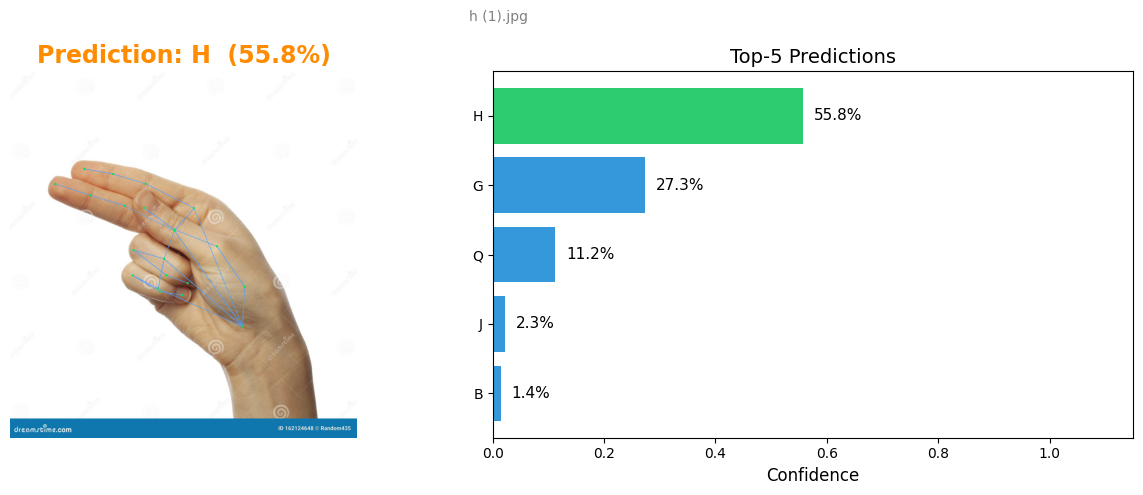


  File      : h (1).jpg
  Predicted : H
  Confidence: 55.76%
  Top-5:
    1. H  ███████████          55.8%
    2. G  █████                27.3%
    3. Q  ██                   11.2%
    4. J                       2.3%
    5. B                       1.4%


✨ Testing: k1 (1).jpg


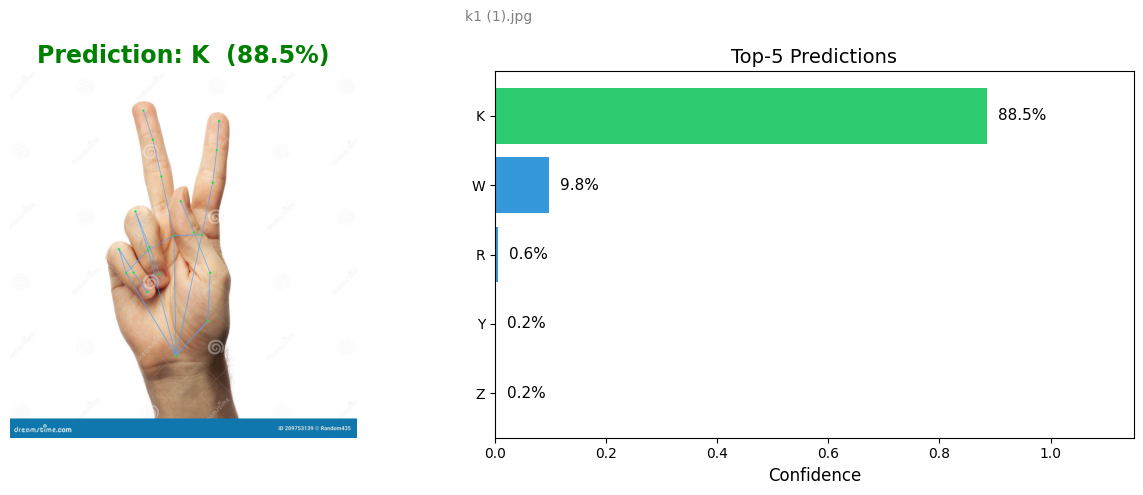


  File      : k1 (1).jpg
  Predicted : K
  Confidence: 88.53%
  Top-5:
    1. K  █████████████████    88.5%
    2. W  █                    9.8%
    3. R                       0.6%
    4. Y                       0.2%
    5. Z                       0.2%


✨ Testing: k (1).jpg


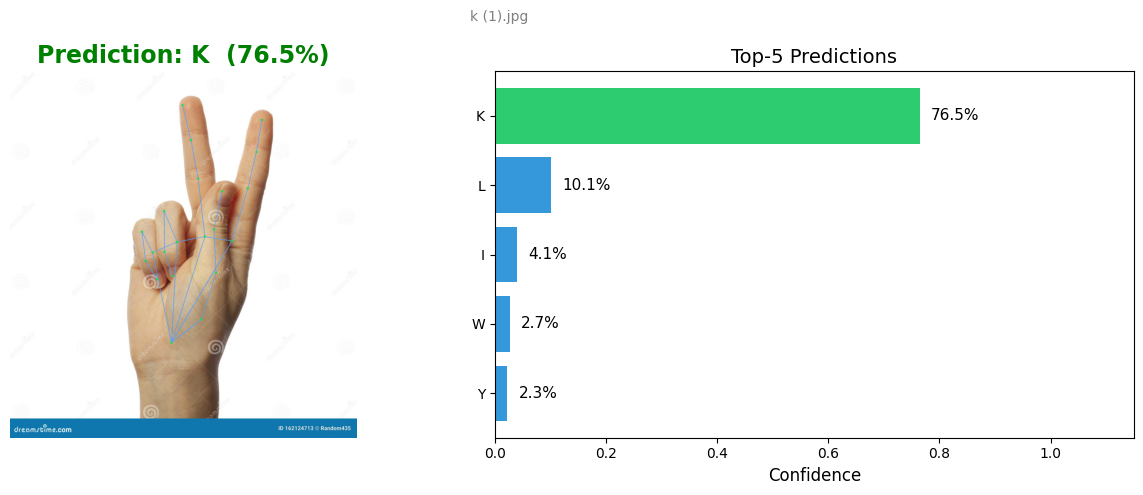


  File      : k (1).jpg
  Predicted : K
  Confidence: 76.50%
  Top-5:
    1. K  ███████████████      76.5%
    2. L  ██                   10.1%
    3. I                       4.1%
    4. W                       2.7%
    5. Y                       2.3%


✨ Testing: i (1).jpg


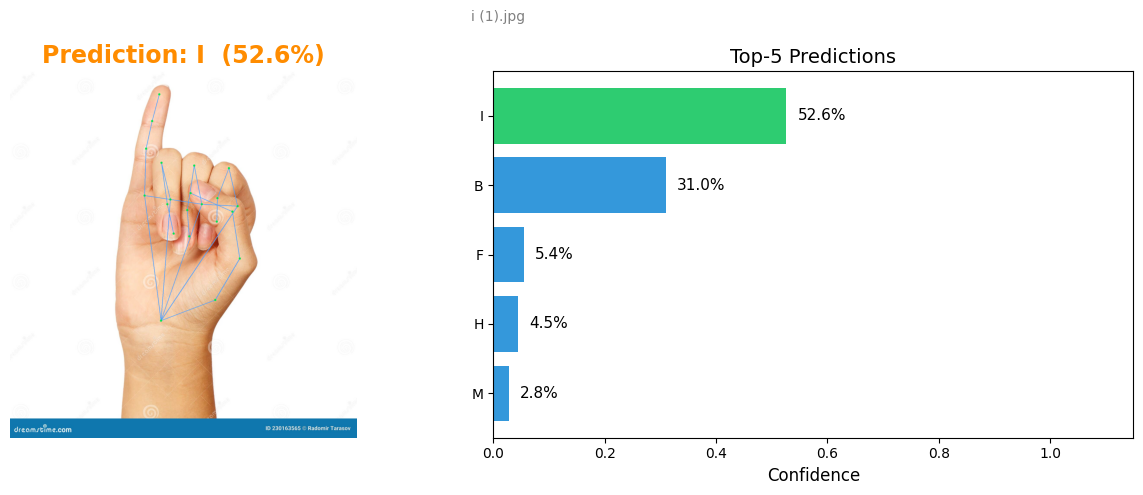


  File      : i (1).jpg
  Predicted : I
  Confidence: 52.61%
  Top-5:
    1. I  ██████████           52.6%
    2. B  ██████               31.0%
    3. F  █                    5.4%
    4. H                       4.5%
    5. M                       2.8%


✨ Testing: man-showing-letter-g-sign-language-isolated-white-background-closeup-finger-spelling-alphabet-american-asl-concept-209753131 (1).jpg


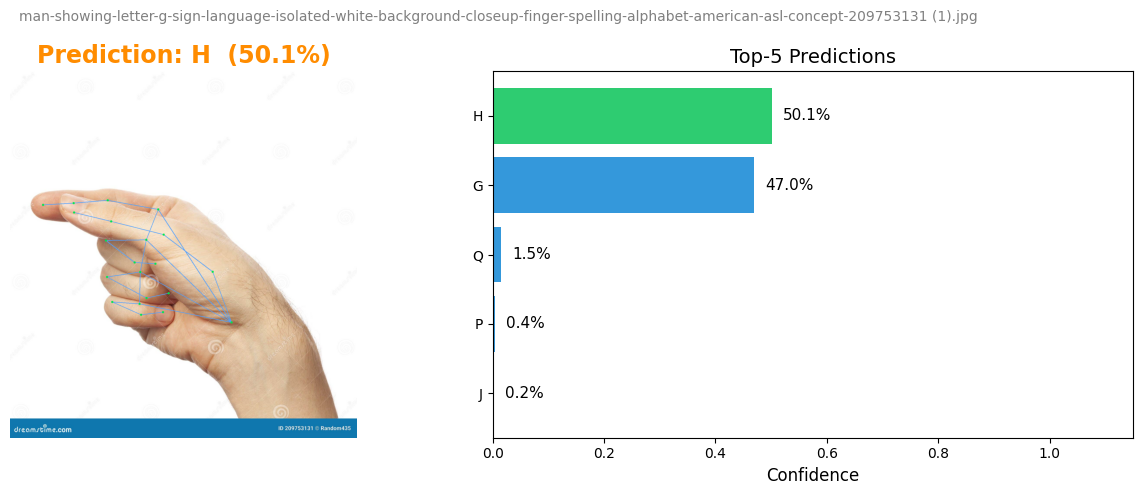


  File      : man-showing-letter-g-sign-language-isolated-white-background-closeup-finger-spelling-alphabet-american-asl-concept-209753131 (1).jpg
  Predicted : H
  Confidence: 50.13%
  Top-5:
    1. H  ██████████           50.1%
    2. G  █████████            47.0%
    3. Q                       1.5%
    4. P                       0.4%
    5. J                       0.2%


✨ Testing: letter-f-sign-language-581411 (1).jpg


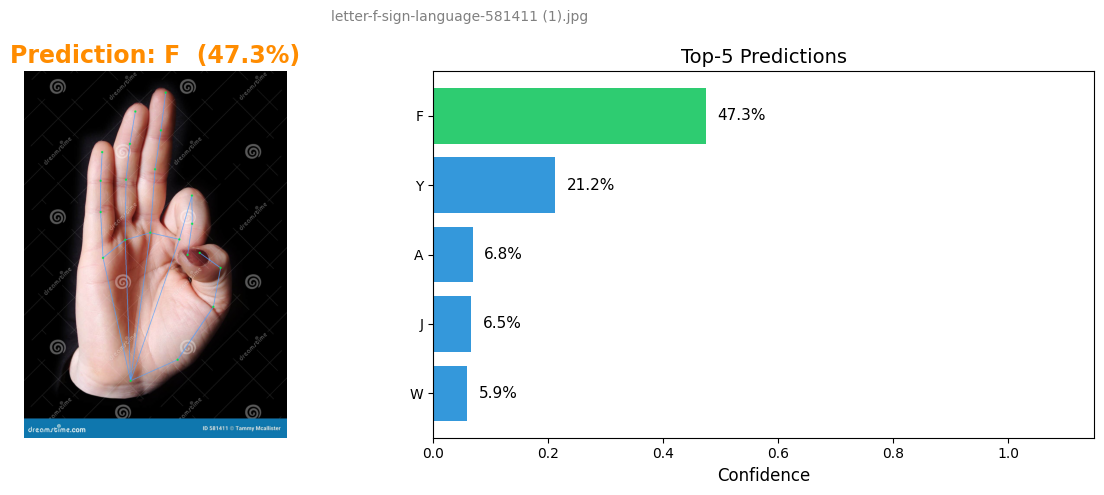


  File      : letter-f-sign-language-581411 (1).jpg
  Predicted : F
  Confidence: 47.35%
  Top-5:
    1. F  █████████            47.3%
    2. Y  ████                 21.2%
    3. A  █                    6.8%
    4. J  █                    6.5%
    5. W  █                    5.9%


✨ Testing: e.jpg


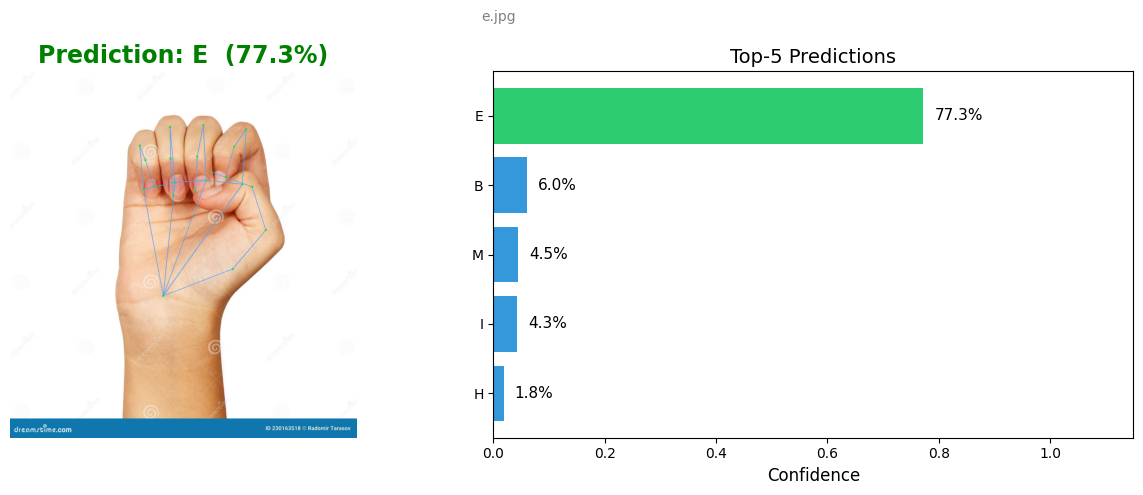


  File      : e.jpg
  Predicted : E
  Confidence: 77.27%
  Top-5:
    1. E  ███████████████      77.3%
    2. B  █                    6.0%
    3. M                       4.5%
    4. I                       4.3%
    5. H                       1.8%


✨ Testing: finger-spelling-letter-d-american-sign-language-white-background-woman-showing-letter-d-isolated-white-asl-concept-finger-162124640 (1).jpg


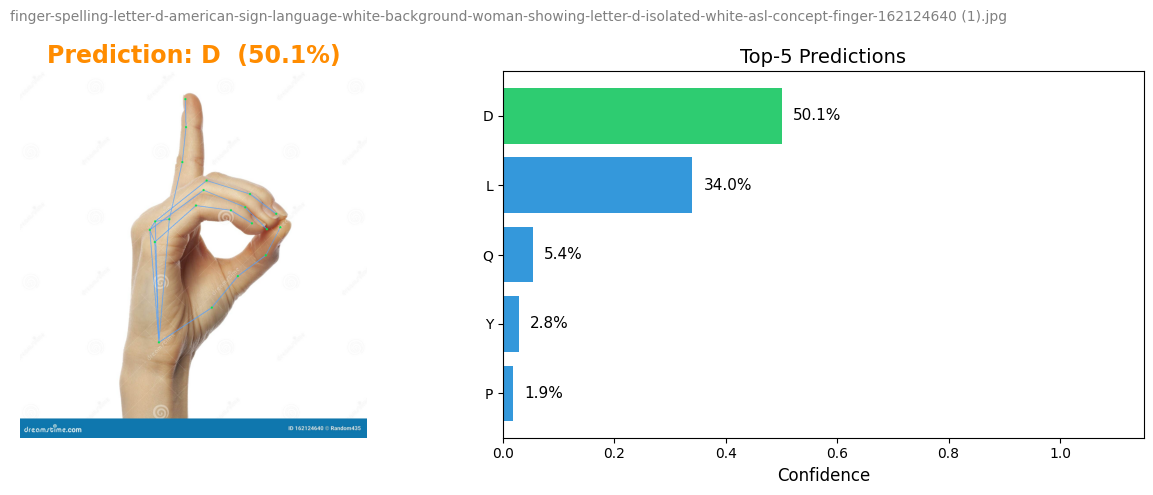


  File      : finger-spelling-letter-d-american-sign-language-white-background-woman-showing-letter-d-isolated-white-asl-concept-finger-162124640 (1).jpg
  Predicted : D
  Confidence: 50.10%
  Top-5:
    1. D  ██████████           50.1%
    2. L  ██████               34.0%
    3. Q  █                    5.4%
    4. Y                       2.8%
    5. P                       1.9%


✨ Testing: letter-b-11763830 (2).jpg


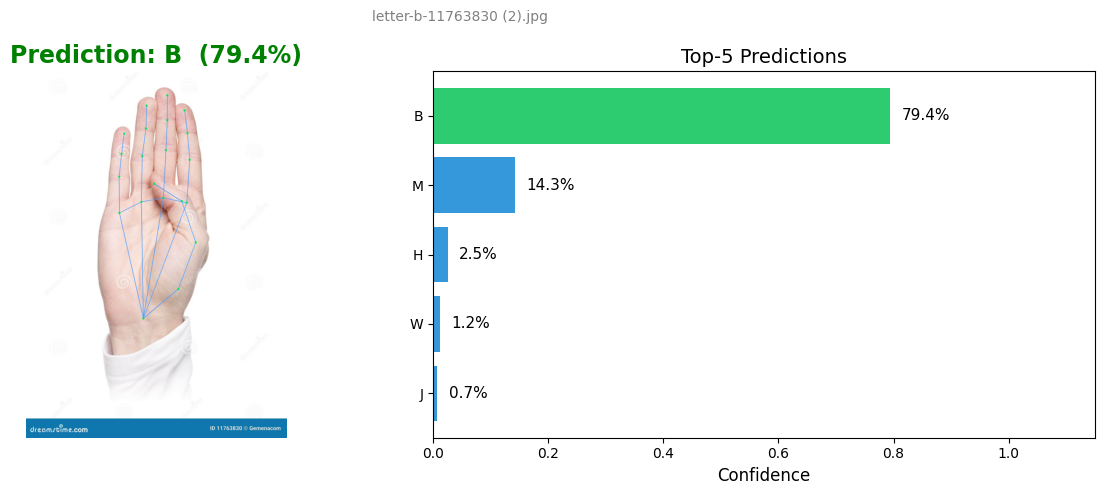


  File      : letter-b-11763830 (2).jpg
  Predicted : B
  Confidence: 79.39%
  Top-5:
    1. B  ███████████████      79.4%
    2. M  ██                   14.3%
    3. H                       2.5%
    4. W                       1.2%
    5. J                       0.7%


✨ Testing: a (3).jpg


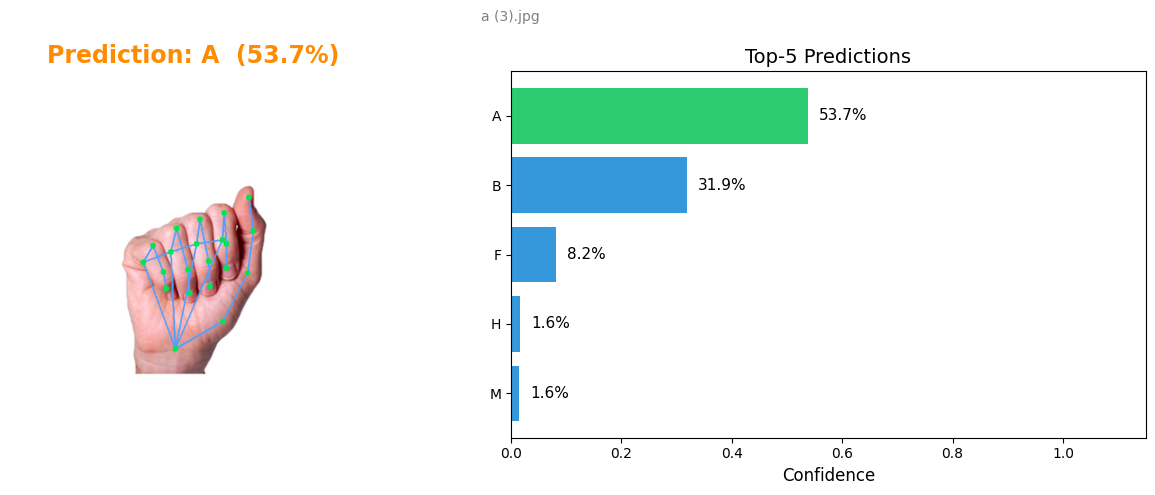


  File      : a (3).jpg
  Predicted : A
  Confidence: 53.74%
  Top-5:
    1. A  ██████████           53.7%
    2. B  ██████               31.9%
    3. F  █                    8.2%
    4. H                       1.6%
    5. M                       1.6%


✨ Testing: istockphoto-1182669471-1024x1024.jpg


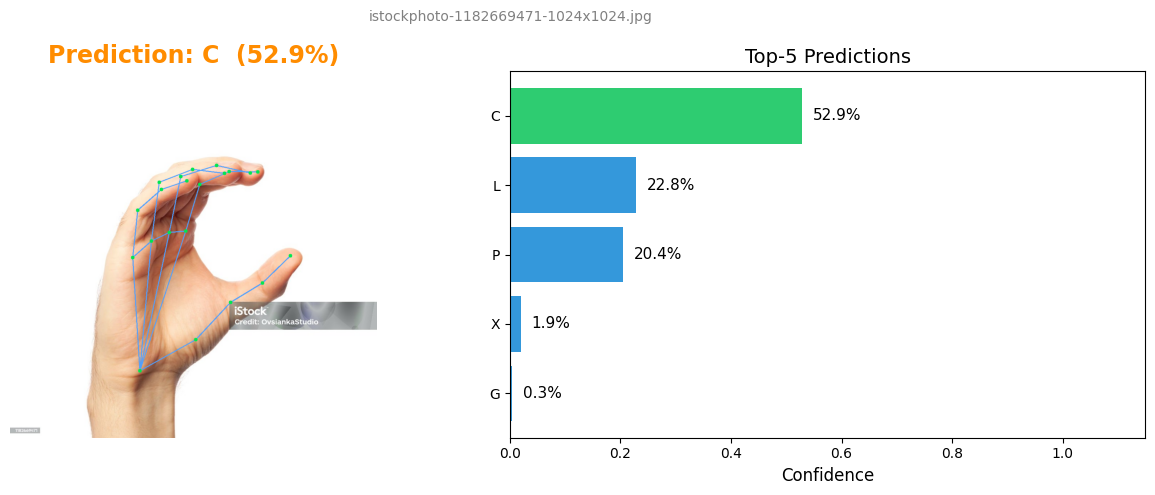


  File      : istockphoto-1182669471-1024x1024.jpg
  Predicted : C
  Confidence: 52.87%
  Top-5:
    1. C  ██████████           52.9%
    2. L  ████                 22.8%
    3. P  ████                 20.4%
    4. X                       1.9%
    5. G                       0.3%


✨ Testing: istockphoto-1182224891-612x612 (1).jpg


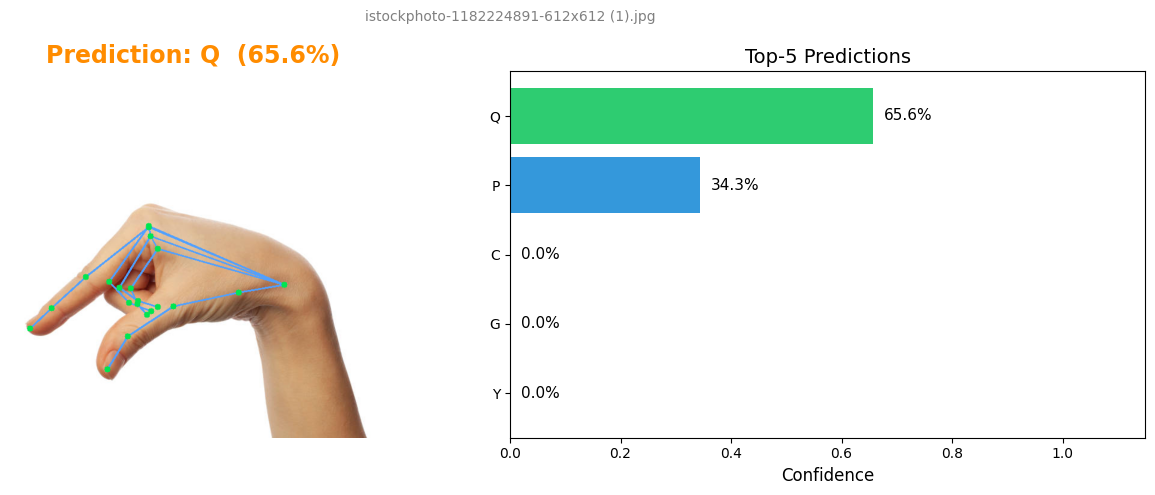


  File      : istockphoto-1182224891-612x612 (1).jpg
  Predicted : Q
  Confidence: 65.65%
  Top-5:
    1. Q  █████████████        65.6%
    2. P  ██████               34.3%
    3. C                       0.0%
    4. G                       0.0%
    5. Y                       0.0%


✨ Testing: pexels-kevin-malik-9017429 (1) (1).jpg


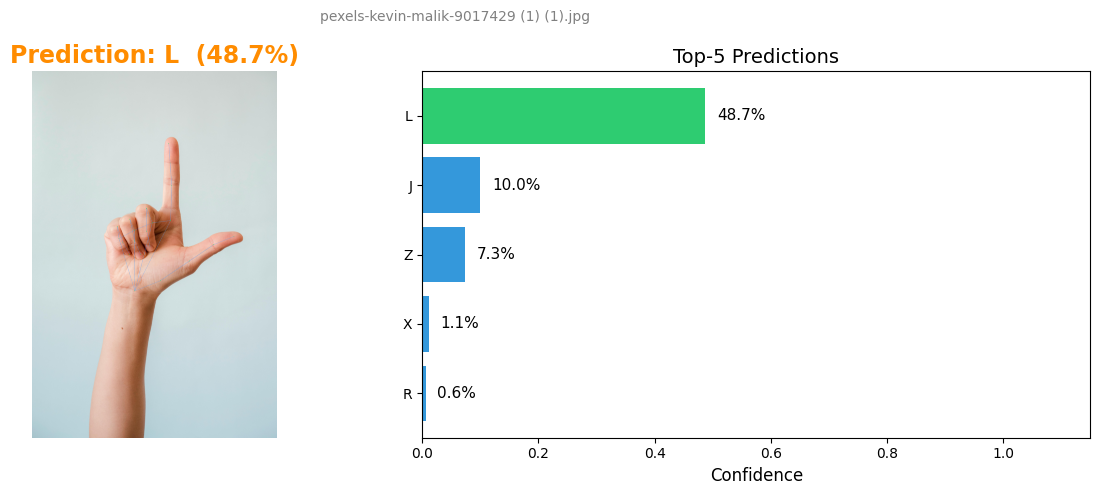


  File      : pexels-kevin-malik-9017429 (1) (1).jpg
  Predicted : L
  Confidence: 48.73%
  Top-5:
    1. L  █████████            48.7%
    2. J  █                    10.0%
    3. Z  █                    7.3%
    4. X                       1.1%
    5. R                       0.6%



In [82]:
# =====================================================================
# Check Ensemble Model working
# =====================================================================

# ======================= STEP 1: INSTALL DEPENDENCIES =======================
!pip install mediapipe opencv-python matplotlib tensorflow --quiet

# ======================= STEP 2: IMPORTS =======================
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import mediapipe as mp
from google.colab import files

# ✅ CORRECT imports for mediapipe 0.10.32
from mediapipe.tasks.python import BaseOptions                          # ← fixed
from mediapipe.tasks.python.vision.hand_landmarker import (
    HandLandmarker,
    HandLandmarkerOptions,
)
from mediapipe.tasks.python.vision import RunningMode                   # ← fixed

print("✅ All imports successful!")
print(f"TensorFlow  : {tf.__version__}")
print(f"MediaPipe   : {mp.__version__}")

# ======================= STEP 3: DOWNLOAD HAND LANDMARKER MODEL =======================
HAND_LANDMARKER_PATH = "/content/hand_landmarker.task"

if not os.path.exists(HAND_LANDMARKER_PATH):
    print("📥 Downloading hand_landmarker.task ...")
    !wget -q -O /content/hand_landmarker.task \
        https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
    print("✅ hand_landmarker.task downloaded!")
else:
    print("✅ hand_landmarker.task already exists.")

# ======================= STEP 4: LOAD YOUR ASL MODEL =======================
MODEL_PATH = "/content/asl_ensemble.keras"

if not os.path.exists(MODEL_PATH):
    print("❌ Model not found! Please upload 'asl_ensemble.keras' to /content/")
else:
    print(f"🔍 Loading model: {MODEL_PATH}")
    model = keras.models.load_model(MODEL_PATH, safe_mode=False)
    print("✅ Model loaded!")
    print(f"   Input shape : {model.input_shape}")
    print(f"   Output shape: {model.output_shape}")

# ======================= STEP 5: INITIALIZE HAND LANDMARKER =======================
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=HAND_LANDMARKER_PATH),
    running_mode=RunningMode.IMAGE,
    num_hands=1,
)

landmarker = HandLandmarker.create_from_options(options)
print("🖐️  Hand Landmarker initialized!")

# ======================= STEP 6: HELPER FUNCTIONS =======================

def get_hand_landmarks(image_bgr):
    """Extract 21 landmarks (x,y) = 42 floats. Returns np.array(42,) or None."""
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    mp_image  = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
    result    = landmarker.detect(mp_image)

    if not result.hand_landmarks:
        return None

    coords = []
    for lm in result.hand_landmarks[0]:
        coords.extend([lm.x, lm.y])
    return np.array(coords, dtype=np.float32)


def preprocess_image(img_bgr, size=96):
    """Resize to (size x size) and normalize to [0,1]."""
    return cv2.resize(img_bgr, (size, size)).astype(np.float32) / 255.0


def draw_landmarks(image_bgr, result):
    """Draw skeleton + keypoints on the image. Returns annotated RGB image."""
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).copy()
    h, w = img.shape[:2]

    if not result.hand_landmarks:
        return img

    hand = result.hand_landmarks[0]
    CONNECTIONS = [
        (0,1),(1,2),(2,3),(3,4),
        (0,5),(5,6),(6,7),(7,8),
        (0,9),(9,10),(10,11),(11,12),
        (0,13),(13,14),(14,15),(15,16),
        (0,17),(17,18),(18,19),(19,20),
        (5,9),(9,13),(13,17),
    ]
    for s, e in CONNECTIONS:
        sx, sy = int(hand[s].x * w), int(hand[s].y * h)
        ex, ey = int(hand[e].x * w), int(hand[e].y * h)
        cv2.line(img, (sx, sy), (ex, ey), (80, 160, 255), 2)
    for lm in hand:
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(img, (cx, cy), 5, (0, 230, 80), -1)

    return img


def predict_asl(image_path, show_landmarks=True, top_k=5):
    """Full prediction pipeline with visualization."""

    # --- Load ---
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"❌ Could not load: {image_path}")
        return

    # --- Detect hand ---
    image_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    mp_image  = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
    result    = landmarker.detect(mp_image)

    if not result.hand_landmarks:
        print("❌ No hand detected!")
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(image_rgb)
        ax.set_title("❌ No Hand Detected", color="red", fontsize=14)
        ax.axis("off")
        plt.show()
        return

    # --- Extract landmarks ---
    coords = []
    for lm in result.hand_landmarks[0]:
        coords.extend([lm.x, lm.y])
    landmarks = np.array(coords, dtype=np.float32)

    # --- Preprocess image ---
    img_proc  = preprocess_image(img_bgr)
    img_batch = np.expand_dims(img_proc, axis=0)   # (1, 96, 96, 3)
    lm_batch  = np.expand_dims(landmarks, axis=0)  # (1, 42)

    # --- Predict ---
    preds      = model.predict([img_batch, lm_batch], verbose=0)[0]
    labels     = [chr(i) for i in range(65, 91)]   # A–Z
    pred_idx   = int(np.argmax(preds))
    pred_label = labels[pred_idx]
    pred_conf  = float(preds[pred_idx])

    # Top-K
    top_k_idx    = np.argsort(preds)[::-1][:top_k]
    top_k_labels = [labels[i] for i in top_k_idx]
    top_k_confs  = [float(preds[i]) for i in top_k_idx]

    # --- Visualize ---
    display_img = draw_landmarks(img_bgr, result) if show_landmarks else image_rgb

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Left: annotated image
    axes[0].imshow(display_img)
    title_color = "green" if pred_conf >= 0.7 else "darkorange"
    axes[0].set_title(
        f"Prediction: {pred_label}  ({pred_conf*100:.1f}%)",
        fontsize=17, fontweight="bold", color=title_color
    )
    axes[0].axis("off")

    # Right: bar chart
    bar_colors = ["#2ecc71"] + ["#3498db"] * (top_k - 1)
    axes[1].barh(top_k_labels[::-1], top_k_confs[::-1], color=bar_colors[::-1])
    axes[1].set_xlim(0, 1.15)
    axes[1].set_xlabel("Confidence", fontsize=12)
    axes[1].set_title(f"Top-{top_k} Predictions", fontsize=14)
    for i, (lbl, conf) in enumerate(zip(top_k_labels[::-1], top_k_confs[::-1])):
        axes[1].text(conf + 0.02, i, f"{conf*100:.1f}%", va="center", fontsize=11)

    plt.suptitle(os.path.basename(image_path), fontsize=10, color="gray")
    plt.tight_layout()
    plt.show()

    # Console summary
    print(f"\n{'='*42}")
    print(f"  File      : {os.path.basename(image_path)}")
    print(f"  Predicted : {pred_label}")
    print(f"  Confidence: {pred_conf*100:.2f}%")
    print(f"  Top-{top_k}:")
    for rank, (lbl, conf) in enumerate(zip(top_k_labels, top_k_confs), 1):
        bar = "█" * int(conf * 20)
        print(f"    {rank}. {lbl}  {bar:<20} {conf*100:.1f}%")
    print(f"{'='*42}\n")

    return pred_label, pred_conf

    # ======================= STEP 7: UPLOAD & RUN =======================
print("\n" + "="*50)
print("📤 Upload one or more ASL hand sign images:")
print("="*50 + "\n")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n✨ Testing: {filename}")
    predict_asl(f"/content/{filename}", show_landmarks=True, top_k=5)

